In [ ]:
from lib.training import train, eval
from lib.data import get_data_chest_x_ray_image, get_chexpert
from lib.utils import get_device
from torch import nn 
import torch
import torch.optim as opt
import pandas as pd
from lib.models import MyResnet, MyMobileNet, MyDenseNet, MyViT

In [ ]:
device = get_device()

In [ ]:
class ExperimentConfig:
    '''
    Classe que define as configurações de um experimento
    '''
    def __init__(self, name, model_fn, loss_fn, optimizer_fn, class_map=None, idx_to_class=None):
        self.name = name
        self.model_fn = model_fn
        self.loss_fn = loss_fn
        self.optimizer_fn = optimizer_fn
        self.class_map = class_map
        self.idx_to_class = idx_to_class

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from lib.data import TransformDataset
from lib.utils import plot_evolution, plot_confusion_matrix
from sklearn.metrics import classification_report

def load_only_model_state(checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    return checkpoint['model_state_dict']

def generate_stat_dataframe(path_to_history : dict, save_name, device):
    '''
    Recebe o path para o local dos checkpoints (de todos os folds) do modelo e junta todos os histories em um dataframe.
    '''
    
    import torch
    from collections import defaultdict
    import pandas as pd
    
    cp_paths = os.listdir(path_to_history)
    cp_paths = [os.path.join(path_to_history, x) for x in cp_paths if '.pt' in x] ## filtering desirable file type
    cp_paths = [x for x in cp_paths if os.path.isfile(x)] ## filtering just files

    df_save_path = os.path.join(path_to_history, f'{save_name}.csv')
    df_data = defaultdict(list)

    for cp_path in cp_paths: 
        checkpoint = torch.load(cp_path, weights_only=False, map_location=device)
        history = checkpoint['metadata']['history']
        
        prefix, ext = os.path.splitext(cp_path)
        fold_number = int(prefix.split('fold=')[-1])
        
        columns = list(history.keys())
        for c in columns: df_data[c].extend(history[c])
        
        repeated_fold_list = [fold_number]*(len(history[columns[0]]))
        df_data['fold'].extend(repeated_fold_list)
        
    results_df = pd.DataFrame(data=df_data)
    results_df.to_csv(df_save_path)
    
    return results_df

def get_fold_of_best_model(results_df: pd.DataFrame, best_by='val_f1_score', best_by_mode='max'):
    '''
    Retorna os melhor modelo de acordo com os resultados do histório de treinamento presente no `results_df`.
    '''
    
    if best_by_mode == "max":
        best_idx = results_df[best_by].idxmax()
    elif best_by_mode == 'min':
        best_idx = results_df[best_by].idxmin()
    else:
        raise ValueError(f'best_by_mode `{best_by_mode}` is not valid')
    selected_fold = results_df.loc[best_idx, 'fold']
    return selected_fold

def prepare_dataloaders(*datasets, batch_size=64, shuffle=True):
    '''
    Recebe um número variável de datasets e retorna uma lista de dataloaders desses datasets na mesma ordem de entrada.
    '''
    num_workers = max(1, os.cpu_count() - 1)
    dataloader_list = []
    for dataset in datasets:
        new_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=True
        )
        dataloader_list.append(new_dataloader)
    return dataloader_list

def get_my_metrics(device, n_classes=2, task='multiclass'):
    '''
    Constroi a coleção de métricas que vai ser usada nos experimentos.
    '''
    import torchmetrics
    from lib.metrics import MetricCollection

    metrics = MetricCollection(device=device)

    if (task == 'multiclass') or (task == 'binary'):
        metrics.register('accuracy', torchmetrics.Accuracy(task='multiclass', num_classes=n_classes))
        metrics.register('precision', torchmetrics.Precision(task='multiclass', num_classes=n_classes, average='macro'))
        metrics.register('recall', torchmetrics.Recall(task='multiclass', num_classes=n_classes, average='macro'))
        metrics.register('f1_score', torchmetrics.F1Score(task='multiclass', num_classes=n_classes, average='macro'))

    elif task == 'multilabel':
        metrics.register('accuracy', torchmetrics.Accuracy(task='multilabel', num_labels=n_classes))
        metrics.register('precision', torchmetrics.Precision(task='multilabel', num_labels=n_classes, average='macro'))
        metrics.register('recall', torchmetrics.Recall(task='multilabel', num_labels=n_classes, average='macro'))
        metrics.register('f1_score', torchmetrics.F1Score(task='multilabel', num_labels=n_classes, average='macro'))

    else:
        raise ValueError(f"Task {task} does not exist. Use 'binary', 'multiclass' or 'multilabel'.")

    return metrics

### target_class --> 0, others --> 1
def get_binary_class_mapping_dict(old_id2class_map : dict, target_label):
    '''
    Recebe um dicionário com vários id's mapeados para os labels e retorna um dicionário em que mapeia os id's que não são iguais ao do target label par 0 
    e que são iguais para 1
    '''
    
    old_idx_to_new_idx = {k:(1 if target_label!= v else 0) for k,v in old_id2class_map.items()}
    new_idx_to_class = {0: target_label, 1 : f'not-{target_label}'}
    return old_idx_to_new_idx, new_idx_to_class
    

def generate_fold_plots(results_df: pd.DataFrame, target_columns, title, save_path=None, highlight=None):
    '''
    Função usada para gerar as curvas de loss dos modelos
    '''

    for fold in results_df['fold'].unique().tolist():
        fold_slice = results_df[results_df['fold'] == fold].reset_index(drop=True)
        column_values = [fold_slice[tc].tolist() for tc in target_columns]
        
        best_epochs = None
        if highlight is not None:      
            best_epochs = []
            for tc in target_columns:
                if highlight == 'max':
                    best_epochs.append(fold_slice[tc].values.argmax() + 1)
                elif highlight == 'min':
                    best_epochs.append(fold_slice[tc].values.argmin() + 1)
        
        if save_path is not None:
            os.makedirs(save_path, exist_ok=True)
            save_full_path = os.path.join(save_path, f'{title}_fold={fold}.png')
        else:
            save_full_path = None
        
        plot_evolution(
            y_values=column_values, 
            y_labels=target_columns, 
            title=title,
            xlabel='Epochs', 
            ylabel='Values', 
            path=save_full_path, 
            #vlines=best_epochs
        )    
        
    return 

def get_fold_number_from_path(path):
    '''
    Extrai o número do fold presente no nome do path
    '''
    prefix, ext = os.path.splitext(path)
    return int(prefix.split('fold=')[-1])

def test_folds_on_test(path_to_models, test_dataset, model_builder, device, idx_to_class_map, experiment_path=None, images_path=None):
    '''
    Testa todos os melhores modelos de cada fold no dataset de teste, reportando o classfication report e matriz de confusão.
    '''
    
    cp_paths = os.listdir(path_to_models)
    cp_paths = [os.path.join(path_to_models, x) for x in cp_paths if ('.pt' in x) and ('best' in x)] ## filtering desirable file type
    cp_paths = [x for x in cp_paths if os.path.isfile(x)] ## filtering just files   
    
    test_dataset = TransformDataset(test_dataset, transform=None)
    test_dataloader = prepare_dataloaders(test_dataset)[0] ## returns a list
    target_names = [idx_to_class_map[i] for i in sorted(idx_to_class_map.keys())]
        
    for cp_path in cp_paths:
        fold_number = get_fold_number_from_path(cp_path)
        
        model_state = load_only_model_state(cp_path, device)
        model = model_builder().to(device=device)
        model.load_state_dict(model_state)
        
        y_true, y_pred = eval(model, test_dataloader, device, task='multiclass')
    
        report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
        
        report_df = pd.DataFrame(report_dict)
        print(f'Classification Report Fold {fold_number}')
        print(report_df)
        
        if experiment_path:
            classification_report_path = os.path.join(experiment_path, f'classification_report_fold={fold_number}.csv')
            report_df.to_csv(classification_report_path)

        if images_path:
            cm_save_path = os.path.join(images_path, f'confusion_matrix_fold={fold_number}.png')     
        
        print(f'Confusion Matrix Fold {fold_number}')       
        plot_confusion_matrix(y_true, y_pred, class_map=idx_to_class_map, save_path=cm_save_path)
        
    return
        

def experiment(config : ExperimentConfig, data_dict, device, metrics, freeze=False, epochs=30, warmup=5, patience=10, mode='train', best_by='val_f1_score', best_by_mode='max'):
    '''
    Função que define um experimento.
    mode=train --> Treina vários modelos utilizando folds já construídos previamente e passados pelo data_dict salvando checkpoints para os melhores modelos de cada fold e o checkpoint ao final do treino.
    mode=results --> Gera confusion matrix, dataframe de resultados e plot de curvas de loss (loss de validação e treino) para todos os folds.
    mode=train+results --> executa sequencialmente os dois modos descritos anteriormente, na mesma ordem.
    '''
    
    save_path = f'experiments/{config.name}_folder'
    images_path = os.path.join(save_path, 'images/')
    
    os.makedirs(save_path, exist_ok=True)   
    os.makedirs(images_path, exist_ok=True)
    
    if mode == 'train' or mode == 'train+results':
        
        folds = data_dict['folds']
        base_dataset = data_dict['base_dataset']
        train_transform = data_dict['train_transform']
        test_transform = data_dict['test_transform']
        
        for fold_idx, (train_idx, val_idx) in enumerate(folds):
            print(f"\n--- Fold {fold_idx+1} ---")
            
            model = config.model_fn().to(device=device)
            
            if freeze: model.freeze()
            else : model.unfreeze()

            optimizer = config.optimizer_fn(model.parameters())
            loss_fn = config.loss_fn()
            
            train_subset = Subset(base_dataset, train_idx)
            val_subset = Subset(base_dataset, val_idx)

            train_dataset = TransformDataset(train_subset, train_transform, class_map=config.class_map)
            val_dataset = TransformDataset(val_subset, test_transform, class_map=config.class_map)
            
            train_dataloader, val_dataloader = prepare_dataloaders(train_dataset, val_dataset)
            
            save_name = f'{config.name}_fold={fold_idx+1}.pt'
            
            history, model = train(
                model, train_dataloader, val_dataloader,
                loss_fn, optimizer,
                save_path=save_path, save_name=save_name,
                device=device, metrics=metrics, verbose=True,
                epochs=epochs, warmup=warmup, patience=patience,
            )
            
    if mode == 'results' or mode == 'train+results':
        print('Generating results ...')
        
        ## constructing the results dataframe, such that it holds the information of all folds
        results_df = generate_stat_dataframe(save_path, f'{config.name}_results', device)  
        
        ## plotting loss evolution graphics
        generate_fold_plots(results_df, ['val_loss', 'train_loss'], 'Loss Evolution Plot', save_path=images_path, highlight='min')
                 
        print('Evaluating Folds on test dataset...')
        test_dataset = data_dict['test_dataset']
        idx_to_class = data_dict['idx_to_class']
        
        test_folds_on_test(save_path, test_dataset, config.model_fn, device, idx_to_class, save_path, images_path)
        
    else:
        raise ValueError(f'mode `{mode}` is not valid')

In [ ]:
data_dict = get_data_chest_x_ray_image(img_size=(224, 224), kfold=5)  
n_classes = len(data_dict['classes'])
metrics = get_my_metrics(device, n_classes=n_classes, task='multiclass')  

In [ ]:
resnet18_config = ExperimentConfig(
    name="resnet18",
    model_fn=lambda: MyResnet(resnet_version='resnet18', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(resnet18_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del resnet18_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
## resnet18 congelada
resnet18_freeze_config = ExperimentConfig(
    name="resnet18_freeze",
    model_fn=lambda: MyResnet(resnet_version='resnet18', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(resnet18_freeze_config, data_dict, device, metrics, freeze=True, epochs=50, mode='train+results')

del resnet18_freeze_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
resnet34_config = ExperimentConfig(
    name="resnet34",
    model_fn=lambda: MyResnet(resnet_version='resnet34', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(resnet34_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del resnet34_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
## resnet34 congelada
resnet34_freeze_config = ExperimentConfig(
    name="resnet34_freeze",
    model_fn=lambda: MyResnet(resnet_version='resnet34', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(resnet34_freeze_config, data_dict, device, metrics, freeze=True, epochs=50, mode='train+results')

del resnet34_freeze_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
mobilenet_v2_config = ExperimentConfig(
    name="mobilenet_v2",
    model_fn=lambda: MyMobileNet(mobilenet_version='mobilenet_v2', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(mobilenet_v2_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del mobilenet_v2_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
mobilenet_v3_large_config = ExperimentConfig(
    name="mobilenet_v3_large",
    model_fn=lambda: MyMobileNet(mobilenet_version='mobilenet_v3_large', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(mobilenet_v3_large_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del mobilenet_v3_large_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
densenet121_config = ExperimentConfig(
    name="densenet121",
    model_fn=lambda: MyDenseNet(densenet_version='densenet121', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(densenet121_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del densenet121_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
densenet161_config = ExperimentConfig(
    name="densenet161",
    model_fn=lambda: MyDenseNet(densenet_version='densenet161', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(densenet161_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del densenet161_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
# Única rede treinada com 100 épocas, já que nos treinamentos era possível perceber que a rede não tinha convergido com 50 épocas.
vit_b_16_config = ExperimentConfig(
    name="vit_b_16",
    model_fn=lambda: MyViT(vit_version='vit_b_16', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(vit_b_16_config, data_dict, device, metrics, freeze=False, epochs=100, mode='train+results')

del vit_b_16_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt

def friedman_test_and_posthoc_nemenyi(experimentpath_modelname_list: list[str], target_column='val_f1_score', alpha=0.05, save_path=None, save_name="cd_diagram.png"):
    '''
    Recebe uma lista de tuplas, onde cada tupla é o path do dataframe de resultados dos folds do modelo e o nome do modelo para ser usado nos plots e tabelas
    Executa o teste de friedman para os modelos e, caso ocorra um indicativo de diferença estatística é feito o teste posthoc nemenyi para os pares dos modelos 
    E a criação de um plot de Critical Difference dos modelos. (usa a biblioteca autorank)
    Para o teste de Friedman, usa a métrica especificada em target_column e se analisa o máximo para essa métrica. No caso default, os modelos são comparados
    pelo máximo do valor do f1 score macro no dataset de validação para cada fold.
    '''
    
    friedman_data_df = pd.DataFrame()
    model_name_list = []  # manter ordem

    for experiment_path, model_name in experimentpath_modelname_list:
        _dir = os.listdir(experiment_path)
        result_df_path = [x for x in _dir if 'results.csv' in x][-1] ## read the result file
        result_df_path = os.path.join(experiment_path, result_df_path)

        result_df = pd.read_csv(result_df_path)
        result_df_max = result_df.groupby('fold').max().reset_index()
        friedman_data_df[model_name] = result_df_max[target_column]
        model_name_list.append(model_name)

    result = autorank(friedman_data_df, alpha=alpha, verbose=True)
    print(create_report(result))
    plot_stats(result)
    
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        
        full_path = os.path.join(save_path, save_name)
        plt.savefig(full_path, dpi=300, bbox_inches="tight")
    
    plt.show()
    plt.close()
    return
        

def generate_models_fold_comparison(
    experimentpath_modelname_list: list[str], 
    target_columns: list[str], 
    save_path=None, 
    save_name='models_fold_comparison'
):
    '''
    Função não é mais utilizada
    '''
    
    stats_list = []
    
    for experiment_path, model_name in experimentpath_modelname_list:
        _dir = os.listdir(experiment_path)
        result_df_path = [x for x in _dir if '.parquet' in x][-1]
        result_df_path = os.path.join(experiment_path, result_df_path)

        result_df = pd.read_parquet(result_df_path)
        
        stats = (
            result_df
            .groupby("fold")[target_columns]
            .agg(["mean", "std"])
        )
        
        stats = stats.stack(level=0).reset_index()          
        stats.rename(columns={"level_1": "metric"}, inplace=True)
        stats["model"] = model_name
        stats_list.append(stats)
        
    final_df = pd.concat(stats_list, axis=0, ignore_index=True)

    if save_path:
        save_file = os.path.join(save_path, f"{save_name}.csv")
        final_df.to_csv(save_file, index=False)
    
    return final_df


def generate_dataset_comparison_dataframe(model, test_dataset, model_classes, dataset_classes, device, save_path=None, save_name='dataset_comparison'):
    '''
    Testa um modelo em um conjunto de teste e cria um dataframe de comparação entre o que o modelo chutou com as classes do outro dataset.
    Se o mesmo dataset em que o modelo foi treinado for passado, o dataframe corresponde a uma matriz de confução.
    Ex.: se o modelo classicou uma amostra como classe A, e classe no dataset passado a amostra é X, um `hit` é considerado, e o par (A, X) é incrementado.
    '''
    
    test_dataloader = prepare_dataloaders(test_dataset, batch_size=64, shuffle=True)[0]   
     
    y_true, y_pred = eval(model, test_dataloader, device=device, task='multiclass')

    comparison_df = pd.DataFrame(data=0, columns=range(len(dataset_classes)), index=range(len(model_classes)))
    
    print(f'Total Number of Predictions : {len(y_pred)}')
    for yt, yp in tqdm((zip(y_true, y_pred))):
        yp_label = int(yp)
        if isinstance(yt, list) or isinstance(yt, np.ndarray):
            comparison_df.iloc[yp_label, [idx for idx,x in enumerate(yt) if int(x) == 1]] += 1
        else:
            comparison_df.iloc[yp_label, yt] += 1

    comparison_df.index = model_classes
    comparison_df.columns = dataset_classes
    
    if save_path:
        full_save_path = os.path.join(save_path, f'{save_name}.csv')
        comparison_df.to_csv(full_save_path)
    return comparison_df



In [ ]:
experimentpath_modelname_list = [
    ('experiments/resnet18_folder/', 'resnet18'),
    ('experiments/resnet34_folder/', 'resnet34'),
    ('experiments/mobilenet_v2_folder/', 'mobilenet v2'),
    ('experiments/mobilenet_v3_large_folder/', 'mobilenet v3 large'),
    ('experiments/densenet121_folder/', 'densenet121'),
    ('experiments/densenet161_folder/', 'densenet161'),
    ('experiments/resnet18_freeze_folder/', 'resnet18 frozen'),
    ('experiments/resnet34_freeze_folder/', 'resnet34 frozen'),
    ('experiments/vit_b_16_folder/', 'ViT b 16'),
]

Fail to reject null hypothesis that data is normal for column resnet18 (p=0.283006>=0.005556)
Fail to reject null hypothesis that data is normal for column resnet34 (p=0.733993>=0.005556)
Fail to reject null hypothesis that data is normal for column mobilenet v2 (p=0.595736>=0.005556)
Fail to reject null hypothesis that data is normal for column mobilenet v3 large (p=0.278818>=0.005556)
Fail to reject null hypothesis that data is normal for column densenet121 (p=0.280460>=0.005556)
Fail to reject null hypothesis that data is normal for column densenet161 (p=0.094620>=0.005556)
Fail to reject null hypothesis that data is normal for column resnet18 frozen (p=0.452943>=0.005556)
Fail to reject null hypothesis that data is normal for column resnet34 frozen (p=0.161676>=0.005556)
Fail to reject null hypothesis that data is normal for column ViT b 16 (p=0.468590>=0.005556)
Using Bartlett's test for homoscedacity of normally distributed data
Rejecting null hypothesis that all variances are eq

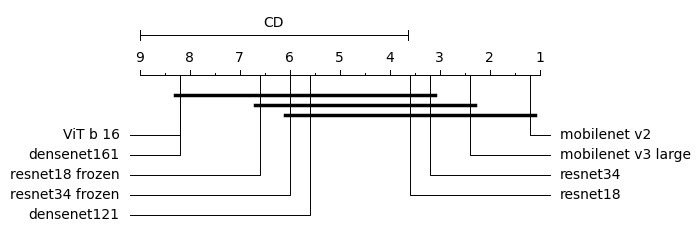

In [109]:
friedman_test_and_posthoc_nemenyi(experimentpath_modelname_list, alpha=0.05, save_path='./')

In [ ]:
## Melhor modelo foi mobilenet v2 e é o que será testado no outro dataset

chexpert_dict = get_chexpert()
chest_x_ray_dict = get_data_chest_x_ray_image()

path_to_mobilenet_v2 = 'experiments/mobilenet_v2_folder/'
results_path = os.path.join(path_to_mobilenet_v2, 'mobilenet_v2_results.csv')
mobilenet_v2_results = pd.read_csv(results_path)

## Selecionando melhor modelo entre os melhores modelos de cada fold para o teste.
fold = get_fold_of_best_model(mobilenet_v2_results, best_by='val_f1_score', best_by_mode='max')

mobilenet_v2_str = 'mobilenet_v2'
checkpoint_path = os.path.join(path_to_mobilenet_v2, f'best_{mobilenet_v2_str}_fold={fold}.pt')

In [ ]:
## Carregando modelo 
model_state = load_only_model_state(checkpoint_path, device)
mobilenet_v2_model = MyMobileNet(mobilenet_version=mobilenet_v2_str, n_classes=3).to(device)
mobilenet_v2_model.load_state_dict(model_state)

<All keys matched successfully>

In [ ]:
## Testando na outra base
dataset_comparison_df = generate_dataset_comparison_dataframe(mobilenet_v2_model, chexpert_dict['train_dataset'], chest_x_ray_dict['classes'],
                                      chexpert_dict['classes'], device, './', 'dataset_comparison')

In [ ]:
dataset_comparison_df